# Window examples

In this notebook we will show how to compute the window function associated with a survey geometry, and build the corresponding window convolution (and wide-angle) matrix in Fourier space to convolve the theory power spectrum with, following https://arxiv.org/abs/2106.06324. Look first at notebook basic_examples.ipynb to understand the *pypower* API.

In [1]:
import os
import tempfile

import numpy as np
import fitsio
from matplotlib import pyplot as plt

from pypower import CatalogFFTPower, CatalogFFTWindow, PowerSpectrumWindow,\
                    BaseMatrix, PowerSpectrumWindowMatrix, PowerSpectrumOddWideAngleMatrix,\
                    mpi, setup_logging

# To activate logging
setup_logging()

In [2]:
base_dir = os.path.join('..', 'pypower', 'tests', 'catalog')
data_fn = os.path.join(base_dir, 'lognormal_data.fits')
randoms_fn = os.path.join(base_dir, 'lognormal_randoms.fits')

# Read input catalogs, scattering on all MPI ranks (1 in this notebook)
def read(fn, columns=('Position', 'WEIGHT_FKP'), ext=1, mpicomm=mpi.COMM_WORLD):
    gsize = fitsio.FITS(fn)[ext].get_nrows()
    start, stop = mpicomm.rank * gsize // mpicomm.size, (mpicomm.rank + 1) * gsize // mpicomm.size
    tmp = fitsio.read(fn, ext=ext, columns=columns, rows=range(start, stop))
    return [tmp[col] for col in columns]

data_positions, data_weights = read(data_fn)
randoms_positions, randoms_weights = read(randoms_fn)

boxcenter = np.array([500.,0.,0.])[None,:]
for positions in [data_positions, randoms_positions]:
    positions += boxcenter

[000000.54]  01-03 09:56  CatalogFFTPower              INFO     Painting catalog 1 to mesh CatalogMesh(nmesh=[128 128 128], boxsize=[2000. 2000. 2000.], boxcenter=[ 5.00000092e+02 -2.13623047e-04  6.25610352e-04], dtype=float32).
[000001.10]  01-03 09:56  CatalogMesh                  INFO     Running interlacing at order 2.
[000001.74]  01-03 09:56  CatalogFFTPower              INFO     Done painting catalog 1 to mesh.
[000001.74]  01-03 09:56  CatalogFFTPower              INFO     Using 40 k-bins between 0.000 and 0.200.
[000002.61]  01-03 09:56  CatalogFFTPower              INFO     Running power spectrum estimation.
[000002.64]  01-03 09:56  CatalogFFTPower              INFO     Applying compensations ({'resampler': 'tsc', 'shotnoise': False}, {'resampler': 'tsc', 'shotnoise': False}).
[000002.80]  01-03 09:56  CatalogFFTPower              INFO     ell = 0 done; 1 r2c completed
[000003.18]  01-03 09:56  numexpr.utils                INFO     NumExpr defaulting to 4 threads.
[000004.1

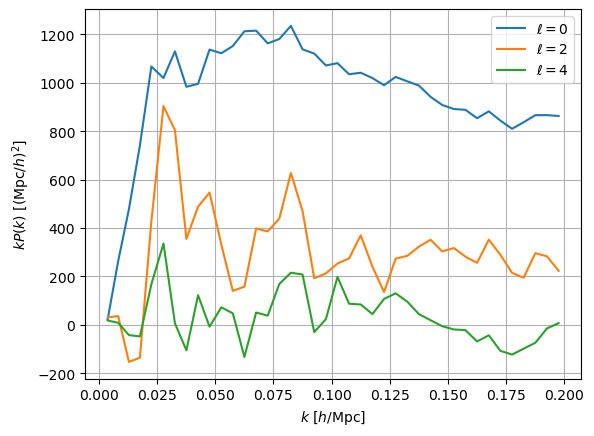

In [3]:
kedges = np.linspace(0, 0.2, 41)
poles = CatalogFFTPower(data_positions1=data_positions, data_weights1=data_weights, randoms_positions1=randoms_positions, randoms_weights1=randoms_weights,
                        boxsize=2000., nmesh=128, resampler='tsc', interlacing=2, ells=(0, 2, 4), los='firstpoint', edges=kedges, position_type='pos', dtype='f4').poles
print('Shot noise is {:.4f}.'.format(poles.shotnoise))
print('Normalization is {:.4f}.'.format(poles.wnorm))
ax = plt.gca()
for ill, ell in enumerate(poles.ells):
    ax.plot(poles.k, poles.k * poles(ell=ell, complex=False), label='$\ell = {:d}$'.format(ell))
ax.legend()
ax.grid(True)
ax.set_xlabel('$k$ [$h/\mathrm{Mpc}$]')
ax.set_ylabel(r'$k P(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.show()

[000006.10]  01-03 09:56  CatalogFFTWindow             INFO     Painting catalog 1 to mesh CatalogMesh(nmesh=[128 128 128], boxsize=[6000. 6000. 6000.], boxcenter=[ 5.00000092e+02 -2.13623047e-04  6.25610352e-04], dtype=float32).
[000006.59]  01-03 09:56  CatalogMesh                  INFO     Running interlacing at order 2.
[000007.18]  01-03 09:56  CatalogFFTWindow             INFO     Done painting catalog 1 to mesh.
[000007.28]  01-03 09:56  CatalogFFTWindow             INFO     Using 3415 k-bins between 0.000 and 0.067.
[000007.40]  01-03 09:56  CatalogFFTWindow             INFO     Running power spectrum estimation.
[000007.44]  01-03 09:56  CatalogFFTWindow             INFO     Applying compensations ({'resampler': 'tsc', 'shotnoise': False}, {'resampler': 'tsc', 'shotnoise': False}).
[000007.67]  01-03 09:56  CatalogFFTWindow             INFO     ell = 0 done; 1 r2c completed
[000010.58]  01-03 09:56  CatalogFFTWindow             INFO     ell = 2 done; 5 r2c completed
[000011.41

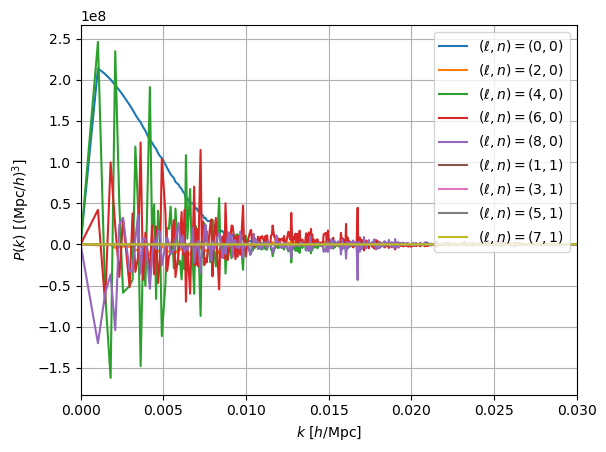

In [4]:
# Let us compute the window function multipoles in k-space
window = CatalogFFTWindow(randoms_positions1=randoms_positions, randoms_weights1=randoms_weights,
                          power_ref=poles, boxsize=6000., position_type='pos', dtype='f4').poles
# You can save the window function
with tempfile.TemporaryDirectory() as tmp_dir:
    fn = os.path.join(tmp_dir, 'tmp.npy')
    window.save(fn)
    window = PowerSpectrumWindow.load(fn)
    print(window.projs)

ax = plt.gca()
for iproj, proj in enumerate(window.projs):
    ax.plot(window.k, window(proj=proj, complex=False), label=proj.latex(inline=True))
ax.legend(loc=1)
ax.grid(True)
ax.set_xlim(0., 0.03)
ax.set_xlabel('$k$ [$h/\mathrm{Mpc}$]')
ax.set_ylabel(r'$P(k)$ [$(\mathrm{Mpc}/h)^{3}$]')
plt.show()

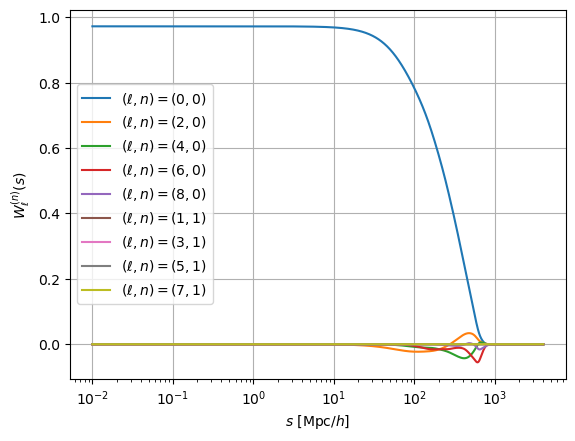

In [5]:
# Let us just take a look at the window function in configuration space
window_real = window.to_real(sep=np.geomspace(1e-2, 4e3, 2048))
ax = plt.gca()
for iproj, proj in enumerate(window_real.projs):
    ax.plot(window_real.sep, window_real(proj=proj), label=proj.latex(inline=True))
ax.legend()
ax.grid(True)
ax.set_xscale('log')
ax.set_xlabel('$s$ [$\mathrm{Mpc}/h$]')
ax.set_ylabel(r'$W_{\ell}^{(n)}(s)$')
plt.show()

In [6]:
# Let us compute the wide-angle and window function matrix
kout = np.linspace(0., 0.3, 120) # output k-bins
ellsin = [0, 2, 4] # input (theory) multipoles
wa_orders = 1 # wide-angle order
ellsout = [0, 2, 4] # output multipoles
sep = np.geomspace(1e-4, 4e3, 2048) # configuration space separation for FFTlog
kinlim = (1e-3, 2e1) # pre-cut input (theory) ks to save some memory
# Input projections for window function matrix:
# theory multipoles at wa_order = 0, and wide-angle terms at wa_order = 1
projsinw = ellsin + PowerSpectrumOddWideAngleMatrix.propose_out(ellsin, wa_orders=wa_orders)
# Window matrix, sum_wa = True means summing over wide-angle terms
wm = PowerSpectrumWindowMatrix(kout, projsin=projsinw, projsout=ellsout, window=window, sep=sep, kinlim=kinlim, sum_wa=True)
# Wide-angle matrix: input projections are theory multipoles at wa_order = 0, return wide-angle terms at wa_order = 1
wam = PowerSpectrumOddWideAngleMatrix(wm.xin[0], projsin=ellsin, projsout=wm.projsin, d=1., wa_orders=wa_orders, los='firstpoint')
# Let us join wide-angle matrix and window function matrix
wawm = BaseMatrix.join(wam, wm)
wm = PowerSpectrumWindowMatrix(kout, projsin=ellsin, projsout=ellsout, window=window, sep=sep, kinlim=kinlim, sum_wa=False)
# You can save the matrix
with tempfile.TemporaryDirectory() as tmp_dir:
    fn = os.path.join(tmp_dir, 'tmp.npy')
    wawm.save(fn)
    wawm = BaseMatrix.load(fn)
# If you change your mind and want to restrict input coordinates further:
kinlim = (1e-3, 1e1)
wawm.select_x(xinlim=kinlim)
print('Input theory limits are {}.'.format((wawm.xin[0].min(), wawm.xin[0].max())))
wm.select_x(xinlim=kinlim)
# You can also rebin e.g. output coordinates by 2, to obtain 120/2 = 60 k-bins
wawm.rebin_x(factorout=2)
print('There are {:d} output k-bins.'.format(len(wawm.xout[0])))
wm.rebin_x(factorout=2)

[000066.03]  01-03 09:57  PowerSpectrumWindowMatrix    INFO     Saving /tmp/tmpwb9ammcn/tmp.npy.
[000066.04]  01-03 09:57  BaseMatrix                   INFO     Loading /tmp/tmpwb9ammcn/tmp.npy.
Input theory limits are (0.0010075865297949438, 9.983540313839276).
There are 60 output k-bins.


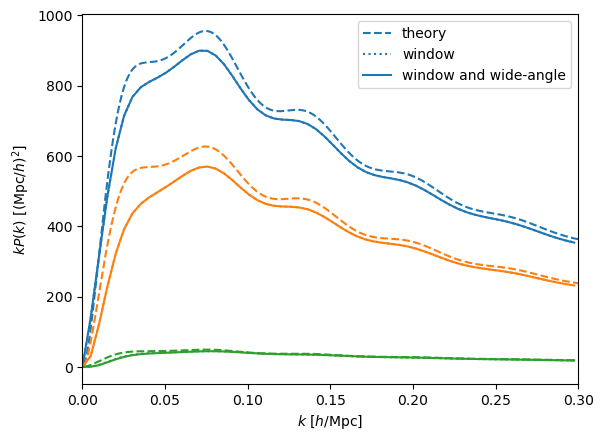

In [7]:
kin = wawm.xin[0]
kout = wawm.xout[0]
# Some theory, just to illustrate the effect of the window function
from cosmoprimo import Cosmology
pklin = Cosmology().get_fourier('eisenstein_hu').pk_interpolator().to_1d()(kin)
def kaiser(f=0.8, bias=1.4):
    beta = f/bias
    toret = []
    toret.append((1. + 2./3.*beta + 1./5.*beta**2)*pklin)
    toret.append((4./3.*beta + 4./7.*beta**2)*pklin)
    toret.append(8./35*beta**2*pklin)
    return toret

pk = kaiser()
pkconv_wm = wm.dot(pk, unpack=True)
pkconv_wawm = wawm.dot(pk, unpack=True)
ax = plt.gca()
for ill in range(len(ellsout)):
    ax.plot(kin, kin*pk[ill], color='C{:d}'.format(ill), linestyle='--', label='theory' if ill == 0 else None)
    ax.plot(kout, kout*pkconv_wm[ill], color='C{:d}'.format(ill), linestyle=':', label='window' if ill == 0 else None)
    ax.plot(kout, kout*pkconv_wawm[ill], color='C{:d}'.format(ill), linestyle='-', label='window and wide-angle' if ill == 0 else None)
ax.set_xlim(0., 0.3)
ax.legend()
ax.set_xlabel('$k$ [$h/\mathrm{Mpc}$]')
ax.set_ylabel(r'$k P(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.show()